In [1]:
import os

In [2]:
os.chdir('/Users/yerrar/Documents/Brain_Cancer')
!pwd

/Users/yerrar/Documents/Brain_Cancer


In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import bbknn
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats

sc.settings.verbosity = 3 
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.3.0
annoy                       NA
appnope                     0.1.2
asttokens                   NA
backcall                    0.2.0
bbknn                       NA
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
cffi                        1.15.1
cloudpickle                 2.0.0
comm                        0.1.2
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.12.0
dask                        2022.7.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
fsspec                      2022.11.0
google                      NA
h5py                        3.7.0
hypergeom_ufunc             NA
igraph                      0.10.2
invgauss_ufunc              NA
ipykernel         

In [4]:
adata_test = sc.read('./H5AD/adata_train.h5ad')
adata_test

AnnData object with n_obs × n_vars = 52027 × 28215
    obs: 'batch', 'index', 'Sample', 'Fragment_Names', 'Patient_Name', 'Grade', 'Sex', 'MGMT_status', 'IDH_status', 'doublet_score', 'predicted_doublets_1', 'n_genes', 'percent_mito', 'n_counts', 'random_ints', 'leiden', 'Res1_2_AC', 'cluster_names', 'cluster_labels'
    var: 'feature_types', 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Patient_Name_colors', 'Res1_2_AC_colors', 'dendrogram_Res1_2_AC', 'dendrogram_cluster_names', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# Cluster Identification

## Classifcation by Marker Genes and Differential Expressed Genes

In [5]:
# Selected Marker Genes

#Tumor Lists
Tumor = ["SOX2"]

#Immune Cell Lists
Immune_cells = ["IL7R","CD3E","CD3D","CD8A","CD8B", "MS4A1", "BANK1","CD79A","MZB1","TNFRSF17",'LILRA4']
Macrophages = ["S100A8", "CD14","LYZ",'FCGR3A','CD1C',"CST3","FCER1G"]
T_cells = ["IL7R","CD3E","CD3D","CD8A","CD8B","NKG7"]
B_cells = ["MS4A1", "BANK1","CD79A"]  

#Brain Cells
Brain_tissue = ["CD163","MBP", "ST18", "MOG","ALDH1L1", "NDRG2", "S100B"]
Microglia = ["CD163"]
Oligo = ["MBP", "ST18", "MOG"]
Pericyte = ["MYO1B", "PDGFRB", "LAMC3"]
Astrocyte = ["ALDH1L1", "NDRG2", "S100B"]

#Other
Endo = ["PECAM1", "VWF", "ANGPT2"]

cell_types = [Tumor, Immune_cells, Macrophages, T_cells, B_cells, Brain_tissue, Microglia, Oligo, Pericyte, Astrocyte,Endo]

cell_names = ['Tumor', 'Immune_cells', 'Macrophages', 'T_cells', 'B_cells', 'Brain_tissue', 'Microglia', 'Oligo', 'Pericyte', 'Astrocyte',
              'Endo']


In [6]:
import warnings
warnings.filterwarnings('ignore')
adata_test.uns['log1p']["base"] = None
sc.tl.rank_genes_groups(adata_test, 'Res1_2_AC', method='t-test')


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:40)


In [7]:
cluster_names = adata_test.obs['Res1_2_AC'].unique()

cell_list = [Tumor, Macrophages, T_cells, B_cells, Microglia, Oligo, Pericyte, Astrocyte, Endo]
cell_list_names = ['Tumor', 'Macrophages', 'T_cells', 'B_cells', 'Microglia', 'Oligo', 'Pericyte', 'Astrocyte','Endo']

for cluster in cluster_names:
    df = sc.get.rank_genes_groups_df(adata_test, group = cluster)
    diff_genes = df['names'].head(20).to_numpy()
    for gene in diff_genes:
        x = 0
        for cell_arr in cell_list:
            if gene in cell_arr:
                print(cluster + ": " + cell_list_names[x] + " --- " + gene)
            x += 1

6: Macrophages --- FCER1G
6: Microglia --- CD163
6: Macrophages --- FCGR3A
3: Macrophages --- FCER1G
2: T_cells --- NKG7
2: T_cells --- CD3D
5: Macrophages --- FCER1G
5: Macrophages --- FCGR3A
16: Macrophages --- S100A8
16: Macrophages --- LYZ
7: T_cells --- CD3D
7: T_cells --- IL7R
7: T_cells --- CD3E
17: Astrocyte --- S100B
17: Macrophages --- CST3
18: Oligo --- MBP
23: B_cells --- CD79A
23: B_cells --- MS4A1
23: B_cells --- BANK1
8: Tumor --- SOX2
8: Macrophages --- CST3
24: Endo --- VWF
9: Tumor --- SOX2
19: Tumor --- SOX2
1: Astrocyte --- S100B
14: Tumor --- SOX2
26: Macrophages --- CST3


## Bulk Classifcation using Gene Scores

In [8]:
x = 0
df_arr = []

for genes_set in cell_types:
    sc.tl.score_genes(adata_test, genes_set,  score_name = cell_names[x] + '_score')
    x+=1
    
df = adata_test.obs.groupby(['Res1_2_AC']).mean().reset_index().groupby('Res1_2_AC').mean()
df

computing score 'Tumor_score'
    finished: added
    'Tumor_score', score of gene set (adata.obs).
    50 total control genes are used. (0:00:01)
computing score 'Immune_cells_score'
    finished: added
    'Immune_cells_score', score of gene set (adata.obs).
    449 total control genes are used. (0:00:01)
computing score 'Macrophages_score'
    finished: added
    'Macrophages_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:01)
computing score 'T_cells_score'
    finished: added
    'T_cells_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:01)
computing score 'B_cells_score'
    finished: added
    'B_cells_score', score of gene set (adata.obs).
    100 total control genes are used. (0:00:01)
computing score 'Brain_tissue_score'
    finished: added
    'Brain_tissue_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:01)
computing score 'Microglia_score'
    finished: added
    'Microg

,doublet_score,n_genes,percent_mito,n_counts,Tumor_score,Immune_cells_score,Macrophages_score,T_cells_score,B_cells_score,Brain_tissue_score,Microglia_score,Oligo_score,Pericyte_score,Astrocyte_score,Endo_score
Res1_2_AC,,,,,,,,,,,,,,,
0,0.054947,1774.931181,0.059622,5242.121582,-1.163510,-0.036785,0.601926,-0.109608,-0.004191,-0.185622,-0.773547,-0.258824,-0.012652,-0.250369,0.020897
1,0.082496,2256.963338,0.049487,5596.356934,0.678534,-0.081816,-0.144940,-0.164105,-0.012476,-0.055741,-1.043003,-0.368648,-0.007410,0.465330,-0.085386
2,0.030902,1153.076795,0.057351,2784.312500,-0.786737,0.491477,-0.191751,1.267220,0.010635,-0.251192,-0.730387,-0.223196,-0.011162,-0.340403,0.003021
3,0.069984,2084.841541,0.048159,7245.291992,-1.272951,-0.038511,1.087839,-0.065096,-0.003780,-0.134461,0.551657,-0.454304,-0.008496,-0.388663,0.049885
4,0.081158,743.789332,0.070148,1696.920654,-0.824232,0.034956,0.711599,0.083314,-0.004184,-0.120400,-0.730750,-0.317258,-0.004879,-0.005100,0.010476
5,0.046403,2593.424328,0.061542,9348.366211,-1.310705,-0.052371,1.148730,-0.112732,-0.002496,-0.123331,0.498379,-0.420835,-0.012488,-0.371453,0.072522
6,0.049386,2206.110245,0.042825,6905.456055,-1.249544,-0.050810,1.189159,-0.105484,0.000087,-0.070169,0.854495,-0.383359,-0.012523,-0.372585,0.083833
7,0.040284,1481.620015,0.060622,4338.057129,-0.900463,0.463278,-0.288669,0.873810,0.002274,-0.324549,-0.840784,-0.319946,-0.005301,-0.395360,-0.037111
8,0.049315,2490.270501,0.078055,6588.084473,0.834176,-0.083742,0.113923,-0.161535,-0.015640,-0.056743,-0.941553,-0.401930,-0.002206,0.423386,-0.070966


In [9]:
del df['doublet_score'] 
del df['n_genes'] 
del df['percent_mito']
del df['n_counts']

In [10]:
from scipy import stats

threshold = 1
scores = ['Tumor_score', 'Macrophages_score', 'T_cells_score', 'B_cells_score', 'Microglia_score', 'Oligo_score', 'Pericyte_score', 'Astrocyte_score', 'Endo_score']
for score_label in scores:
    z_scores = stats.zscore(df[score_label])
    outliers = df[abs(z_scores) > threshold]
    print(score_label + ": ")     
    print(outliers.index.tolist())





Tumor_score: 
['1', '5', '8', '9', '13', '14', '19']
Macrophages_score: 
['3', '5', '6', '7', '14', '16', '18', '20', '22']
T_cells_score: 
['2', '7', '22', '28']
B_cells_score: 
['23']
Microglia_score: 
['3', '5', '6', '16', '20']
Oligo_score: 
['18', '25']
Pericyte_score: 
['21', '24']
Astrocyte_score: 
['1', '8', '9', '14', '16', '17', '18', '20', '28']
Endo_score: 
['24']


In [11]:
df.to_csv("Cluster_GeneScore_matrix.csv")

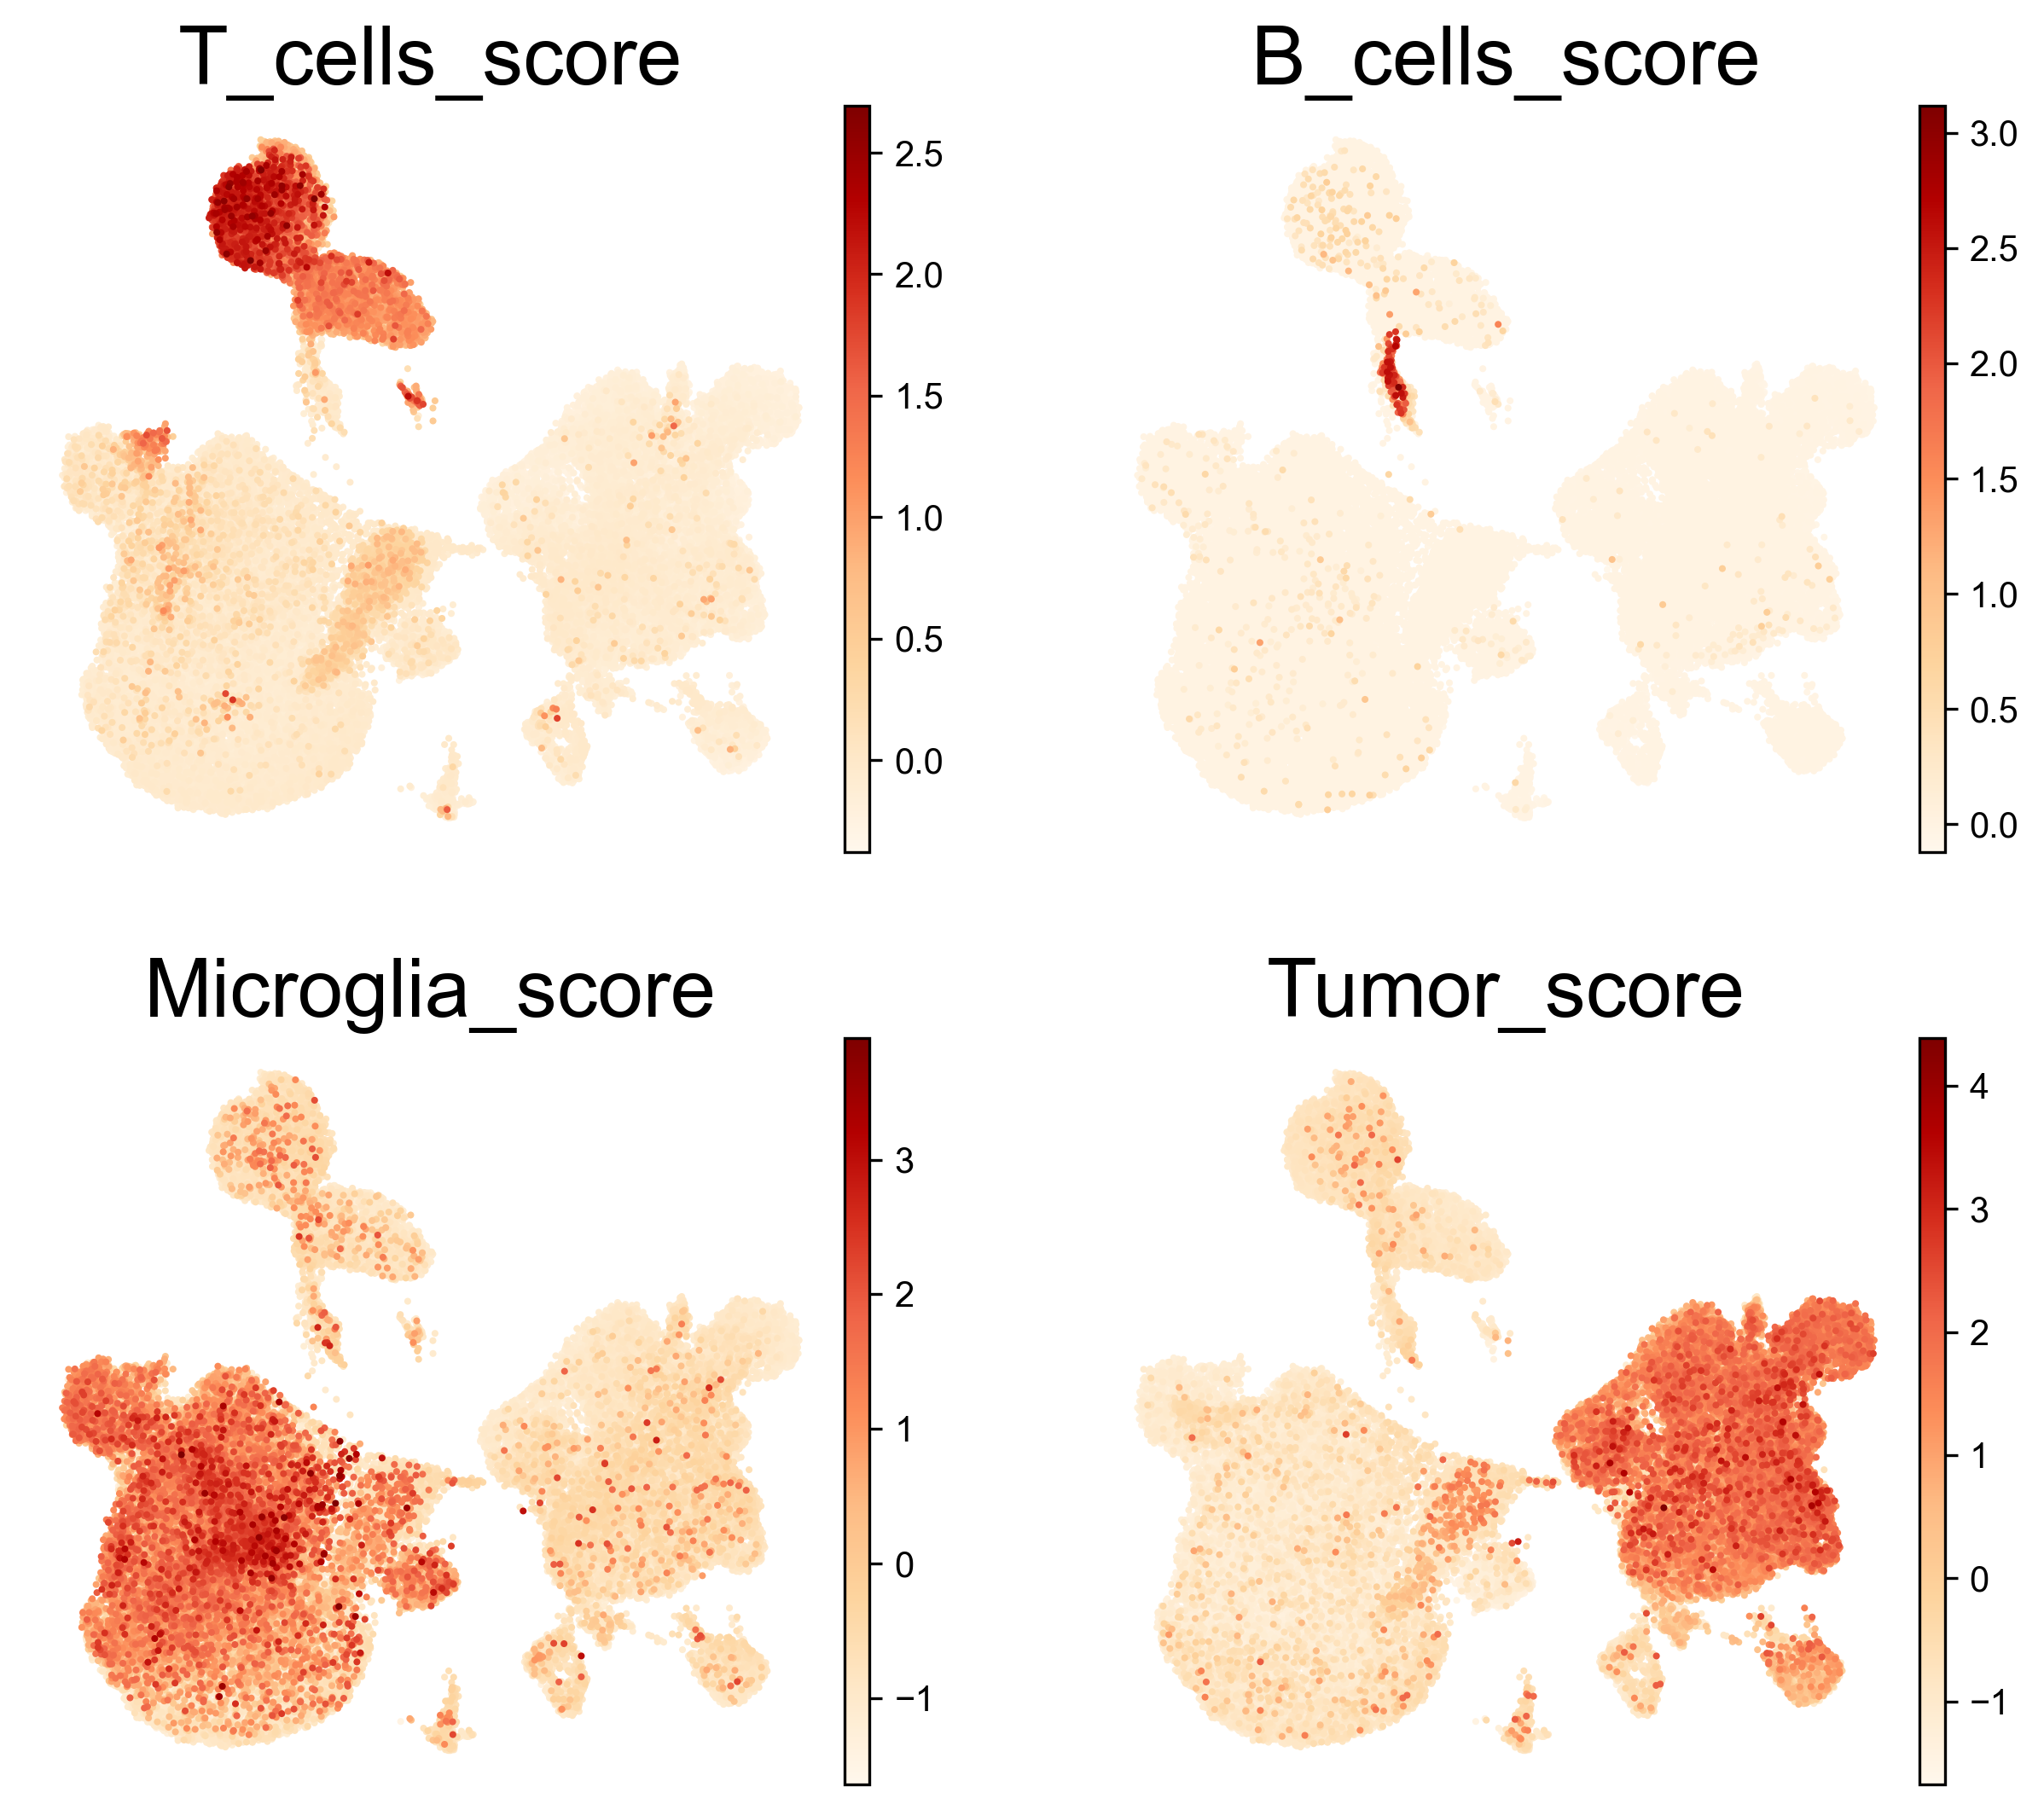

NoneType

In [21]:
#---- UMAP Plots of Select Genes
from matplotlib import rcParams
matplotlib.style.use('default')
rcParams['figure.figsize'] = (3,3)
sc.settings.set_figure_params(dpi=150)  # set sufficiently high resolution for saving
plt.rc('font', size=23)          # controls default text sizes
plt.rc('axes', titlesize=23)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
genes = ['T_cells_score', 'B_cells_score', 'Microglia_score', "Tumor_score"]

plot = sc.pl.umap(adata_test,
           color=genes,
           color_map='OrRd',
           legend_loc='on data',
           legend_fontsize=10,
           size=15,
           ncols=2,
           frameon=False)
type(plot)

## Tree Based Classification Approach using Gene Scores

Tumor_score: 
['1', '8', '9', '11', '13', '14', '17', '19', '27']


Text(0, 0.5, 'Tumor Score Z-Scores')

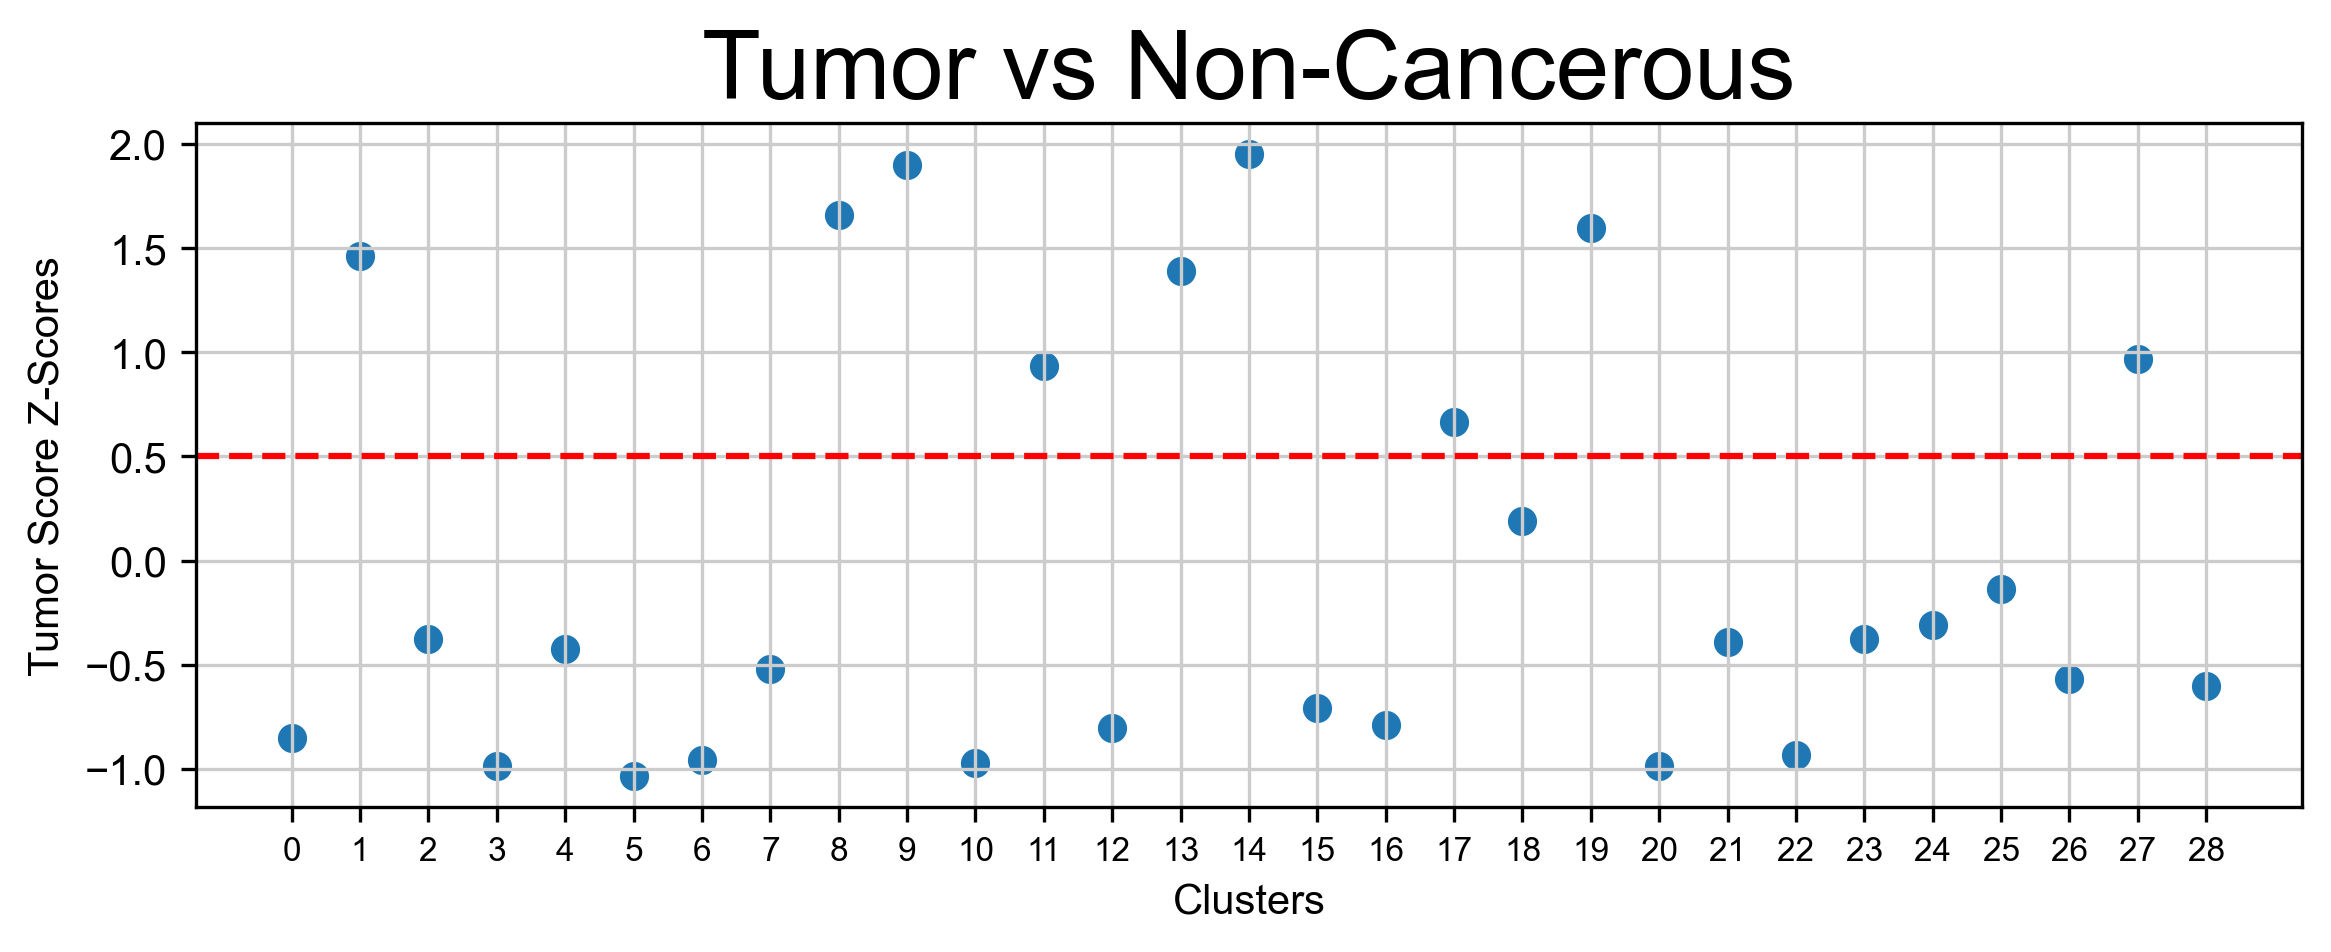

In [20]:
# Tree Approach

#----Tumor or Not
scores = ['Tumor_score']
clust_list = df.index.tolist()
threshold = 0.5
from scipy import stats
for score_label in scores:
    z_scores = stats.zscore(df[score_label])
    outliers = df[z_scores > threshold]
    print(score_label + ": ")
    tumor_clust = outliers.index.tolist()
    print(tumor_clust)
    df['cluster_labels'] = 'Tumor'
df_filt = df[~df.index.isin(tumor_clust)]

fig, ax = plt.subplots(figsize=(9, 3))
ax.scatter(z_scores.index.tolist(), z_scores.tolist())
ax.axhline(y = threshold, color='r', linestyle='--')
for label in ax.xaxis.get_ticklabels():
    label.set_fontsize(8)
ax.set_xlabel('Clusters')
ax.set_title('Tumor vs Non-Cancerous')
ax.set_ylabel('Tumor Score Z-Scores')

Immune_cells_score: 
['2', '7', '22', '23', '28']


Text(0, 0.5, 'Z-Scores')

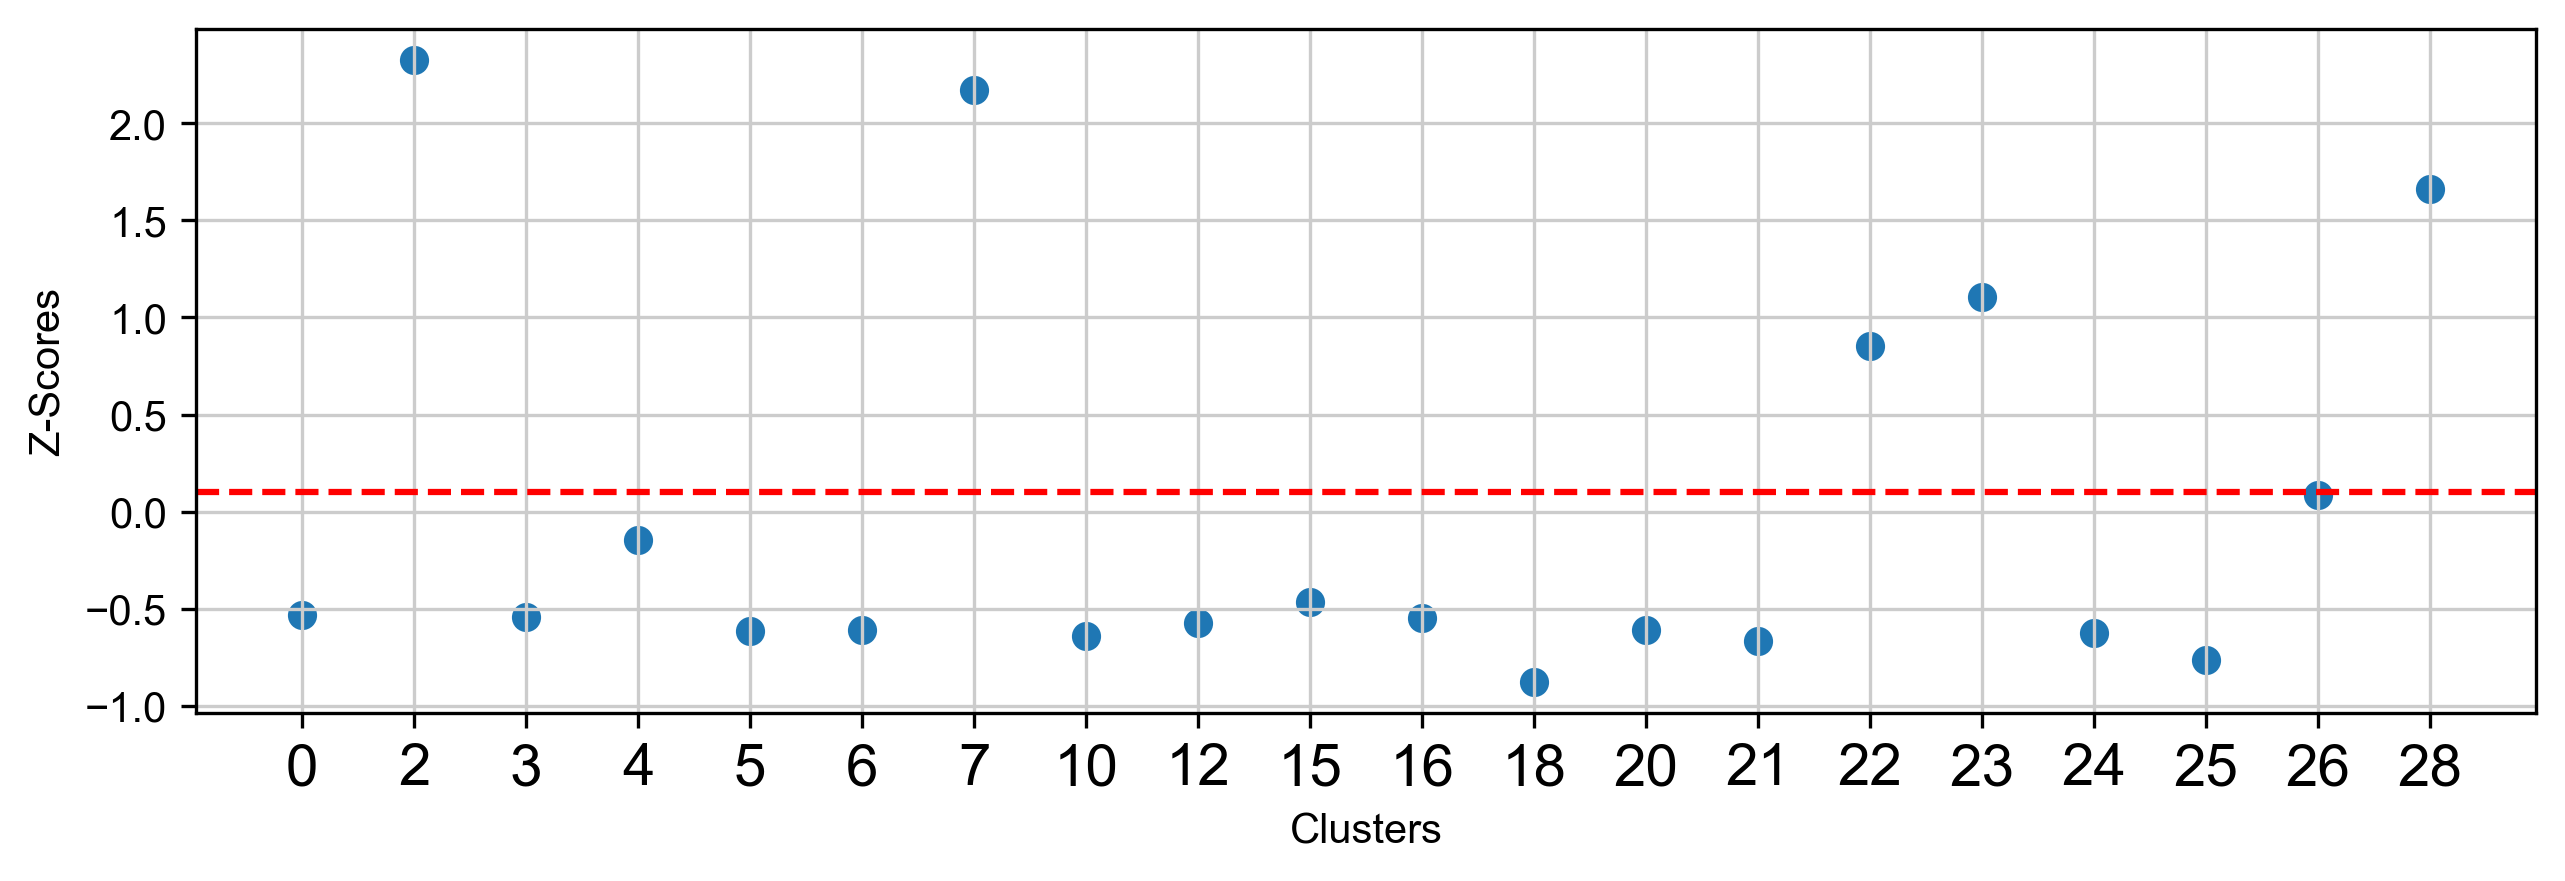

In [23]:
#----Immune Cells or Not
scores = ['Immune_cells_score']
threshold = 0.1
from scipy import stats
for score_label in scores:
    z_scores = stats.zscore(df_filt[score_label])
    outliers = df_filt[z_scores > threshold]
    print(score_label + ": ")
    immune_clust = outliers.index.tolist()
    print(immune_clust)

immune_df = df_filt[df_filt.index.isin(immune_clust)]
brain_df =  df_filt[~df_filt.index.isin(immune_clust)]

fig, ax = plt.subplots(figsize=(10, 3))
ax.scatter(z_scores.index.tolist(), z_scores.tolist())
ax.axhline(y = threshold, color='r', linestyle='--')
ax.set_xlabel('Clusters')
ax.set_ylabel('Z-Scores')

Macrophages_score: 
['22']
T_cells_score: 
['2', '7', '28']
B_cells_score: 
['23']


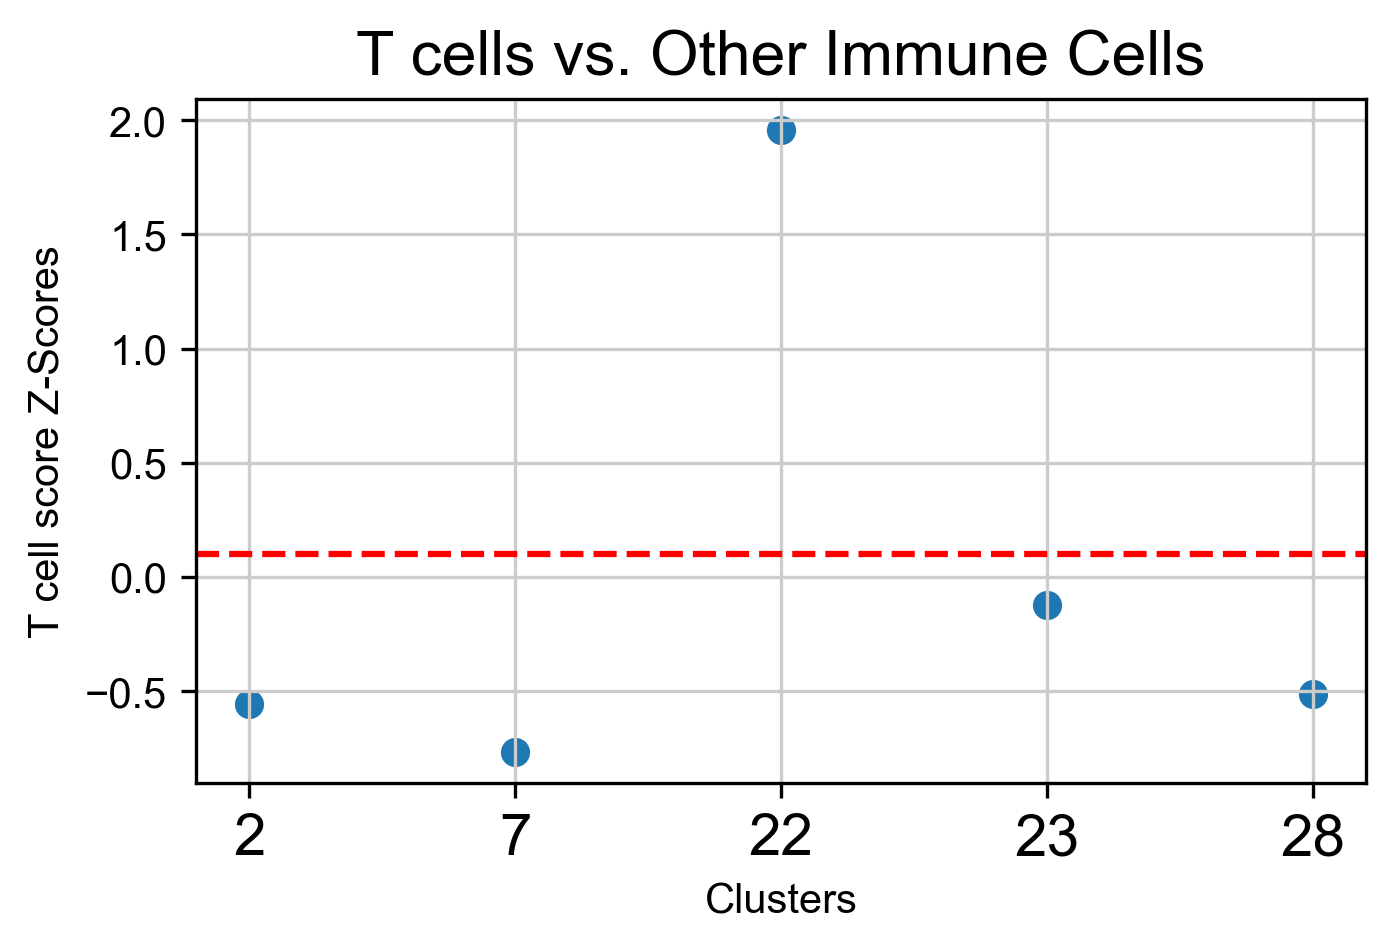

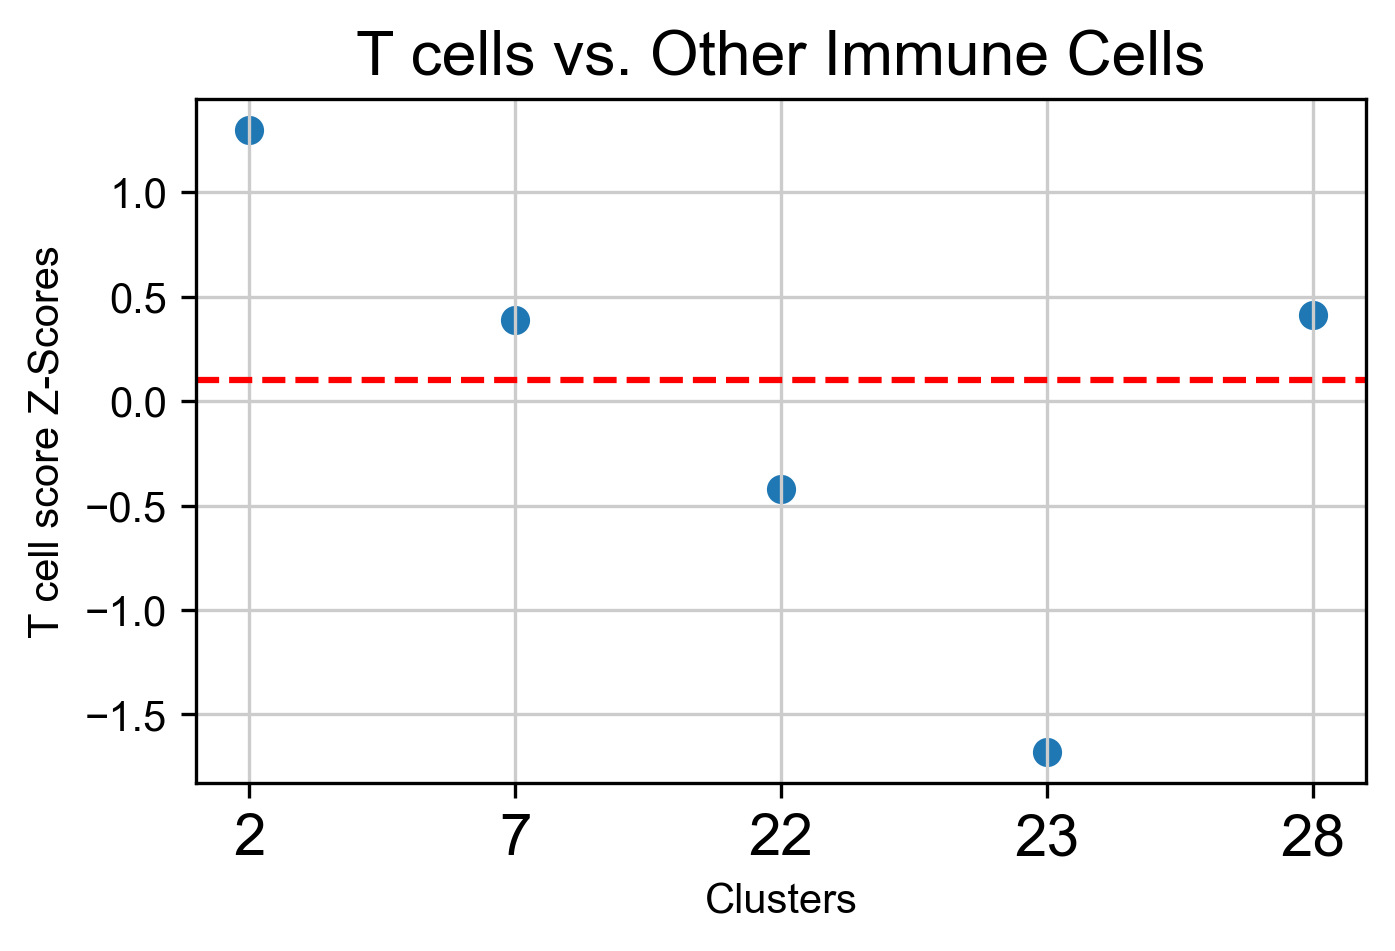

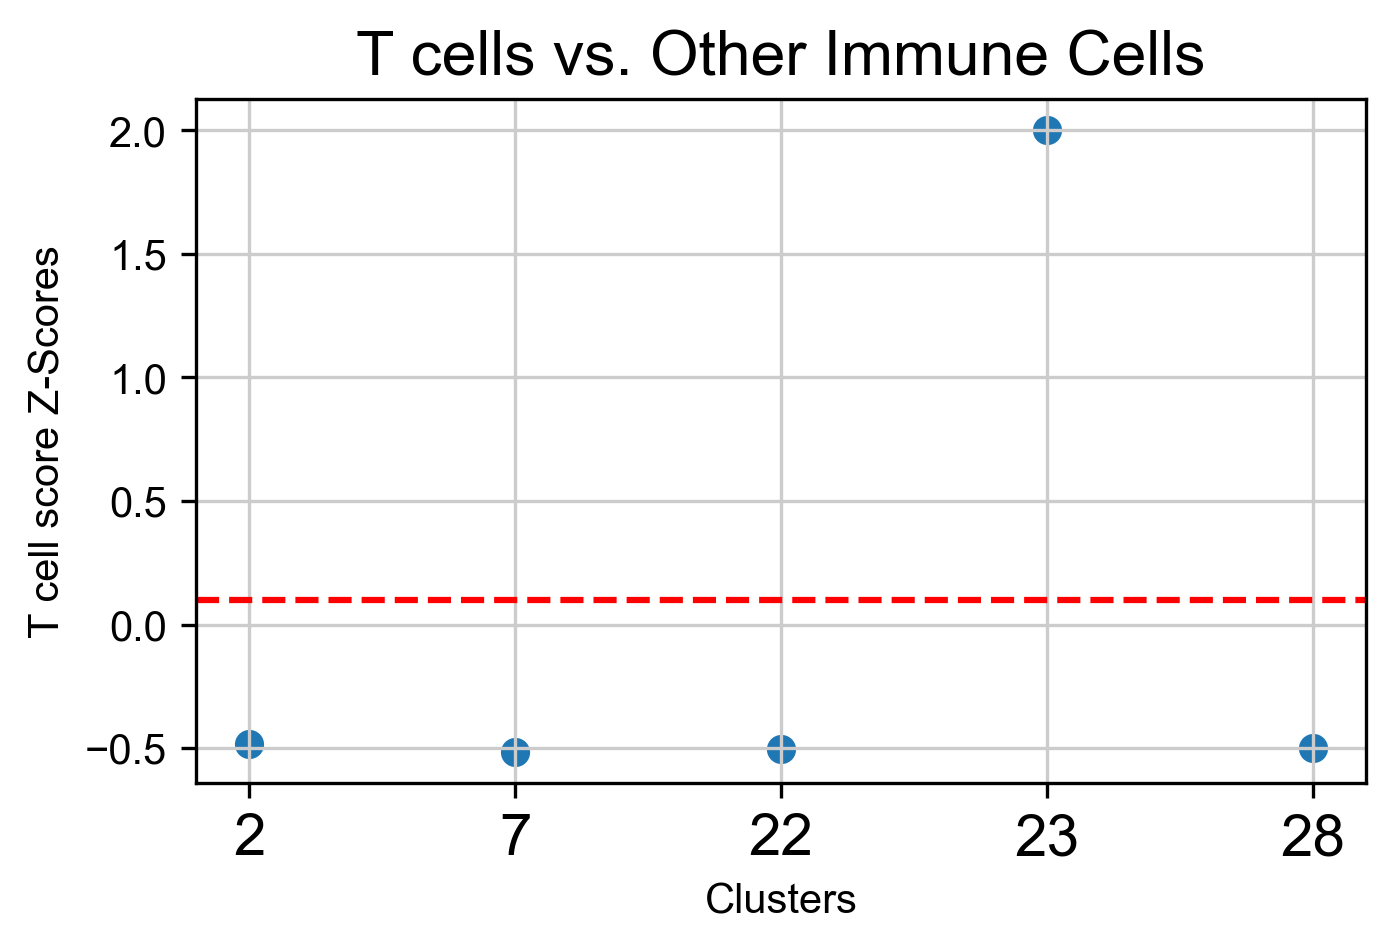

In [31]:
# Classifying Immune Cells
scores = ['Macrophages_score', 'T_cells_score', 'B_cells_score']
names = ['Macrophages', 'T cells', 'B cells']

x = 0
threshold = 0.1
from scipy import stats
for score_label in scores:
    z_scores = stats.zscore(immune_df[score_label])
    outliers = immune_df[z_scores > threshold]
    print(score_label + ": ")
    immune_clust = outliers.index.tolist()
    print(immune_clust)
    for cluster in immune_clust:
        df.loc[df.index == cluster, 'cluster_labels'] = names[x]
    x += 1
    
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.scatter(z_scores.index.tolist(), z_scores.tolist())
    ax.axhline(y = threshold, color='r', linestyle='--')
    ax.set_xlabel('Clusters')
    ax.set_title('T cells vs. Other Immune Cells', fontsize = 15)
    ax.set_ylabel('T cell score Z-Scores')

Endo_score: 
['24']
Pericyte_score: 
['21']
Oligo_score: 
['18']
Astrocyte_score: 
['4', '25', '26']


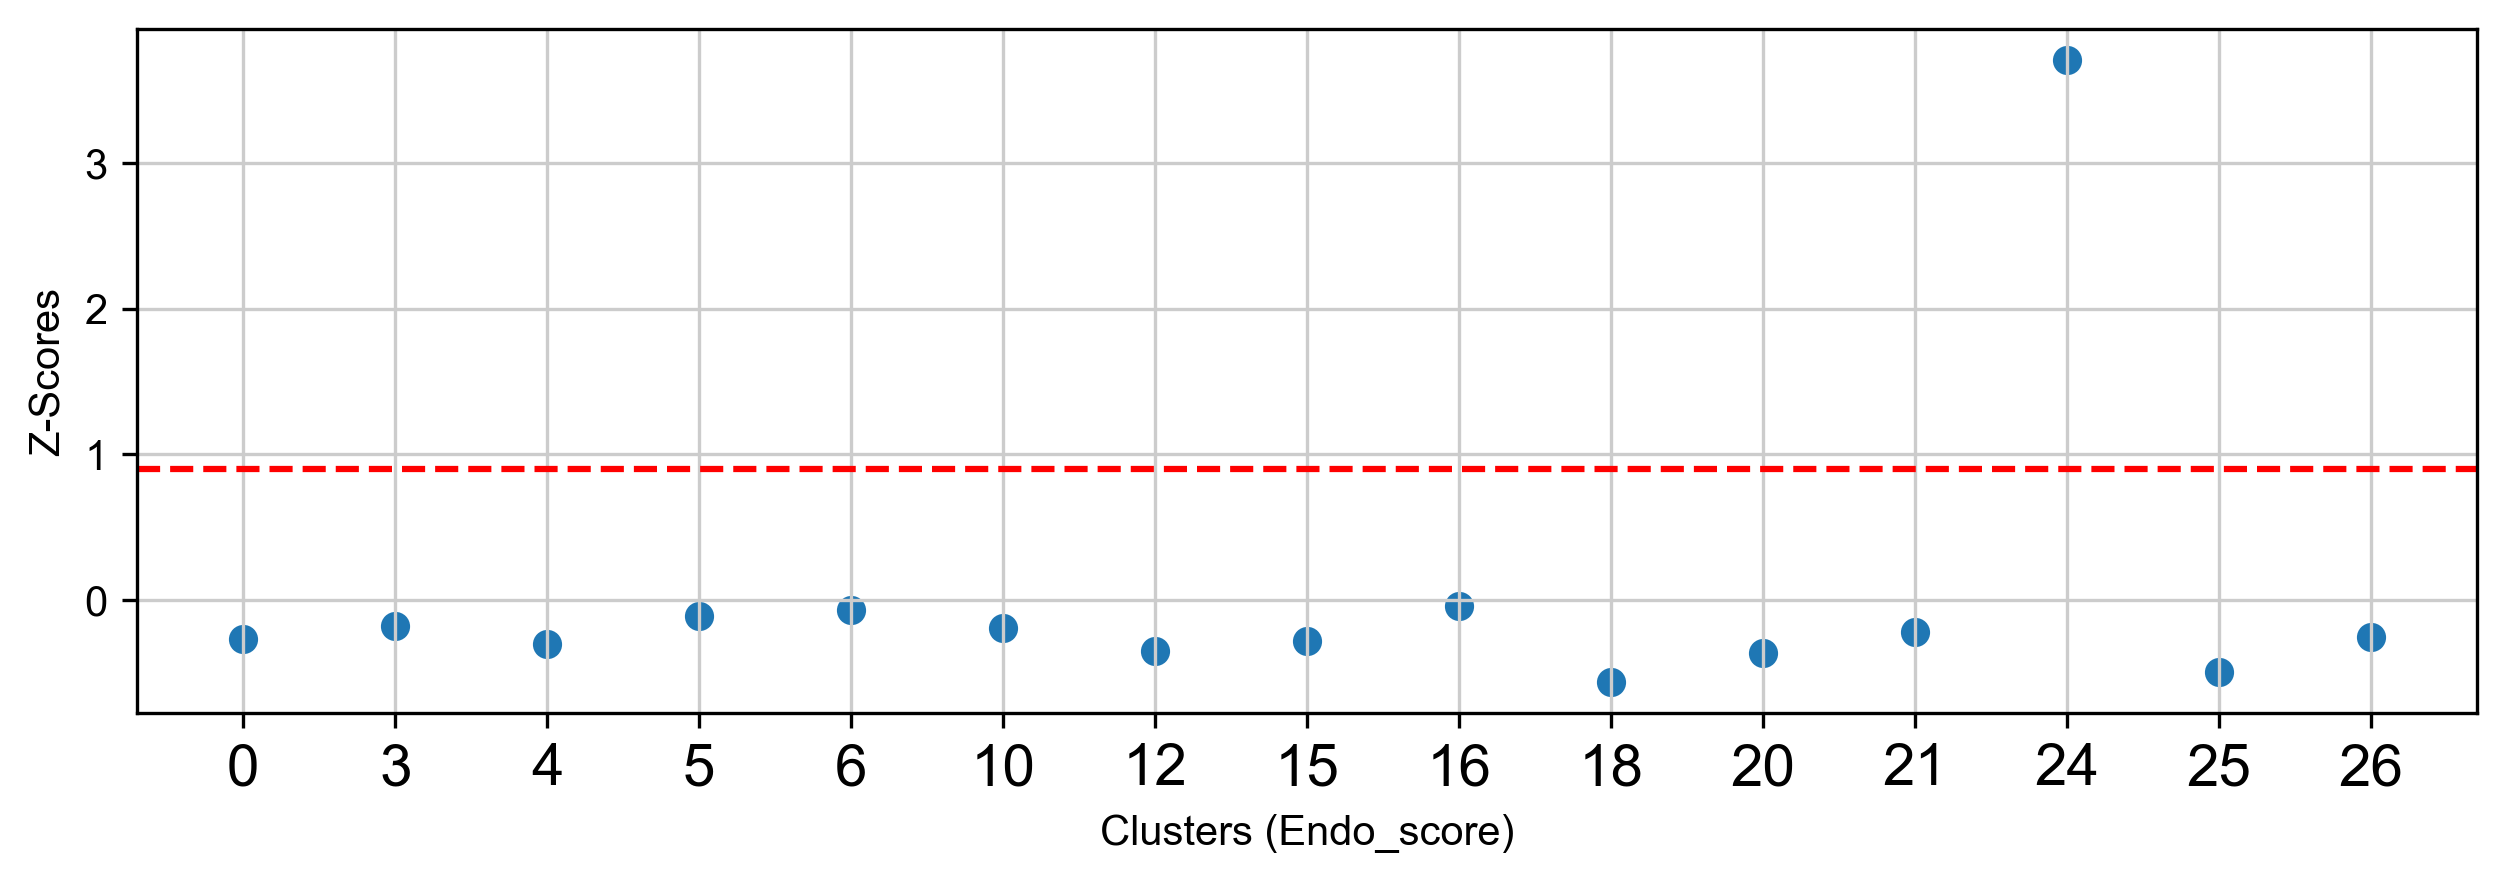

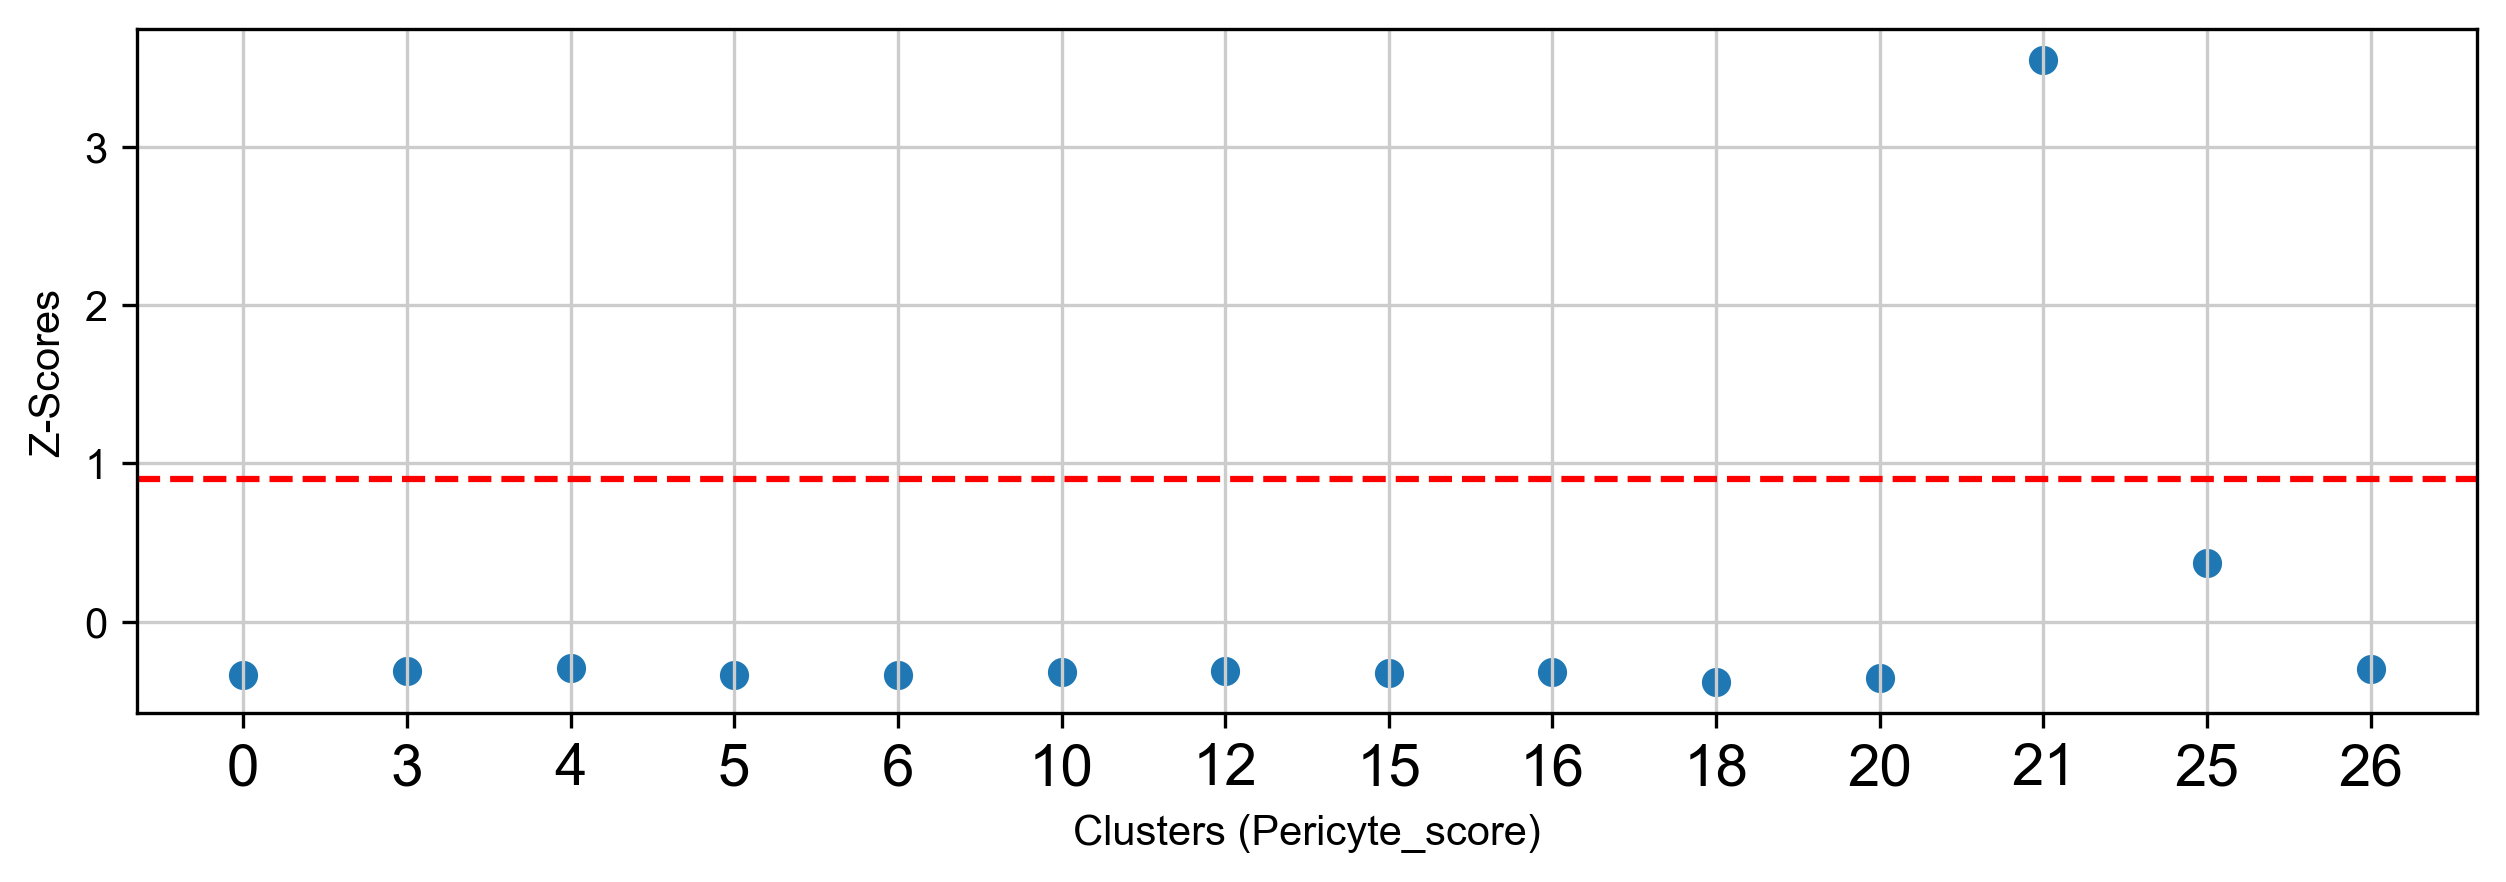

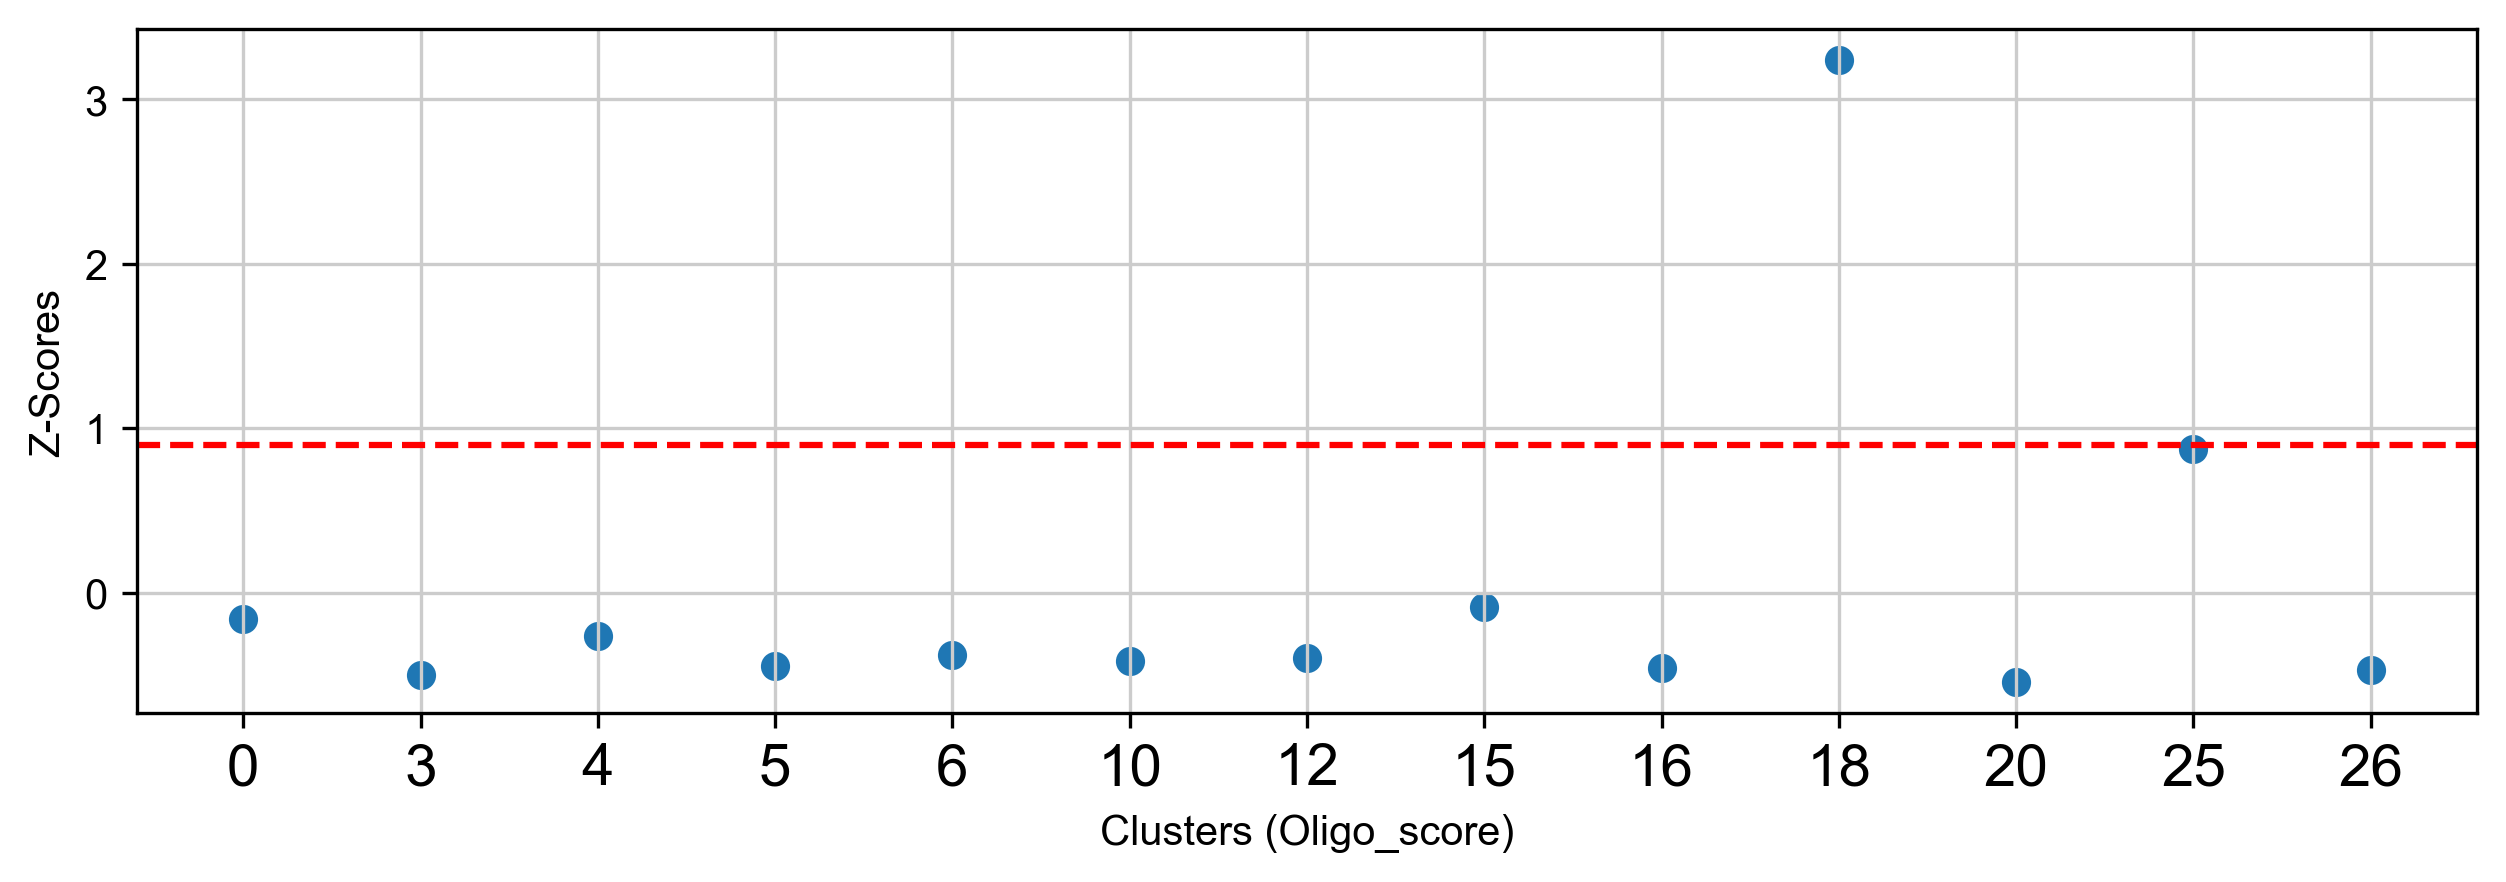

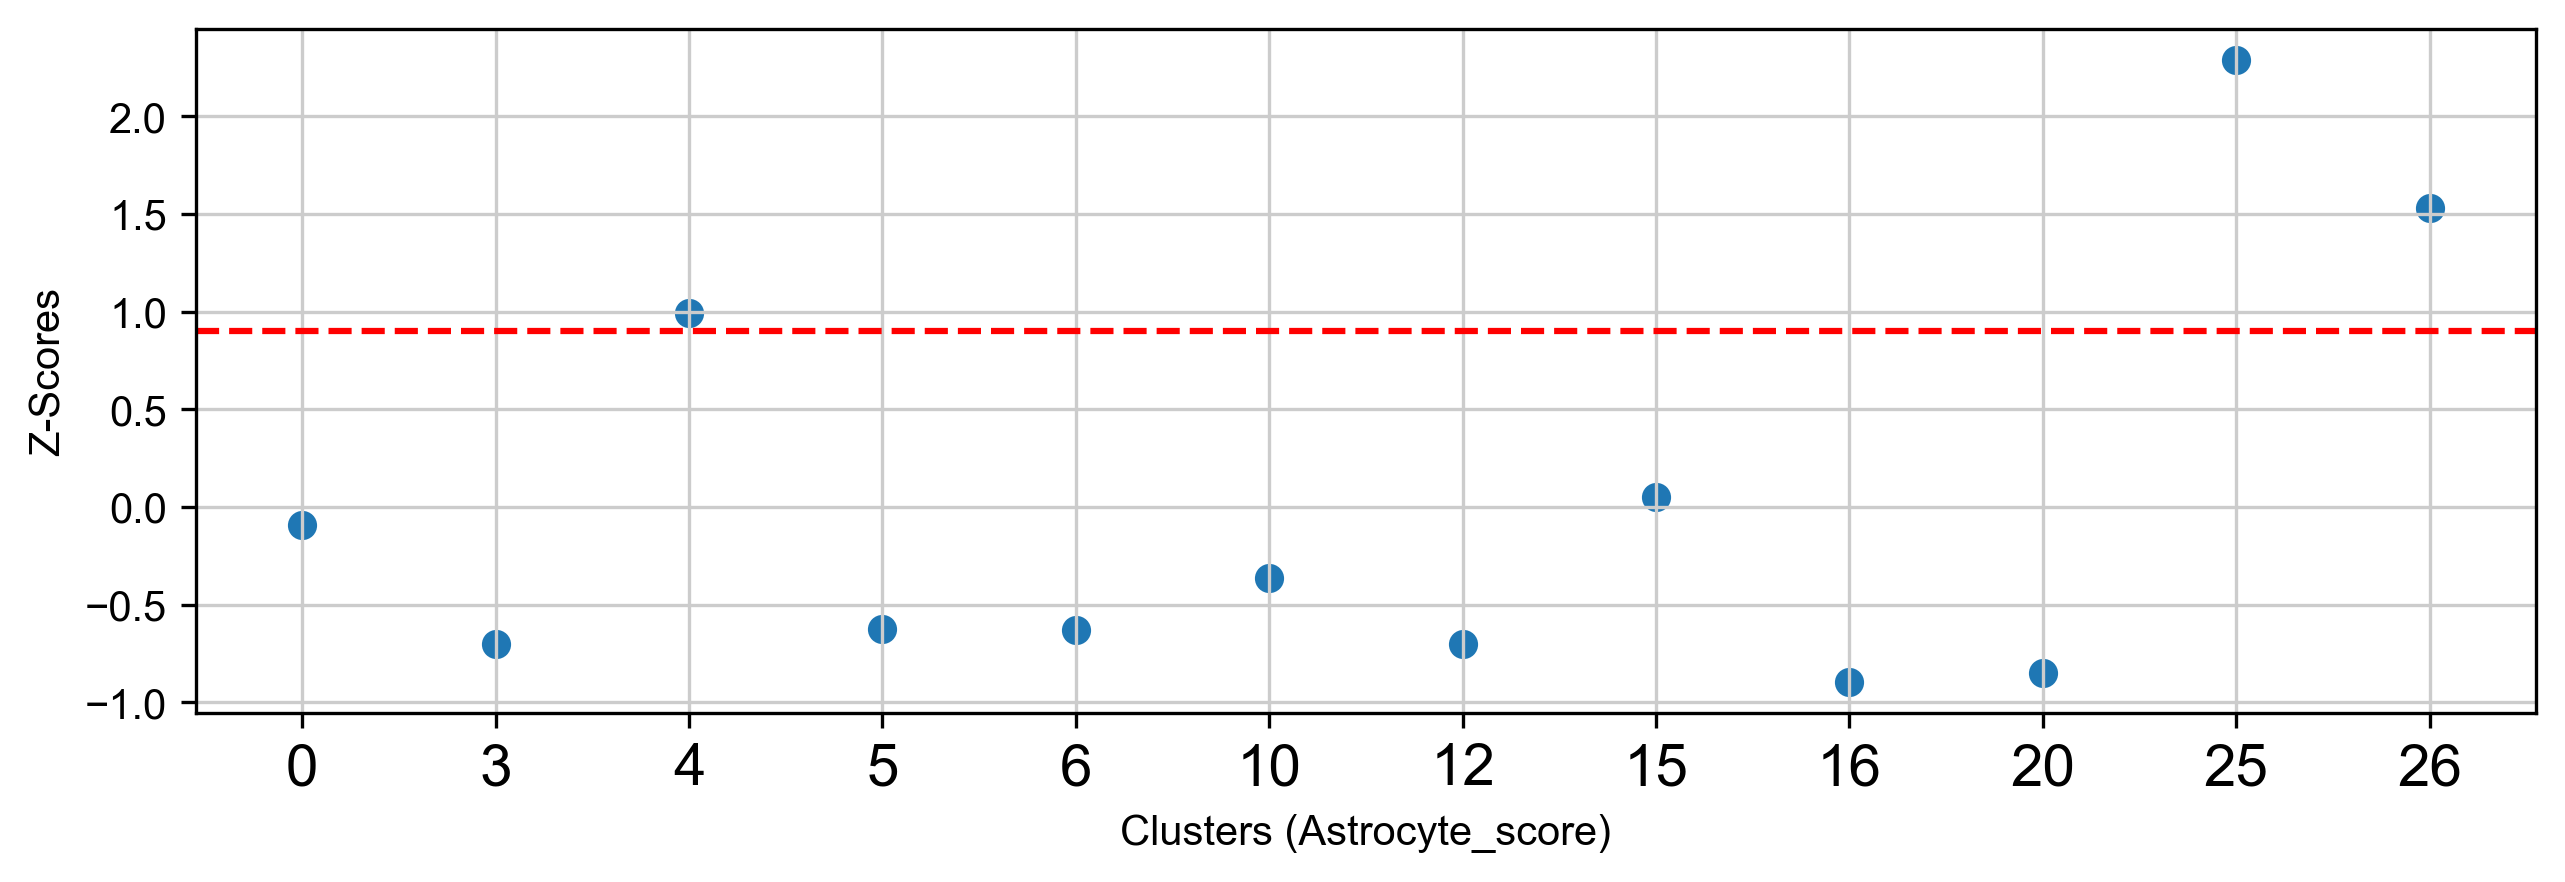

In [16]:
# Classifying Brain Tissue
scores = ['Endo_score','Pericyte_score','Oligo_score',  'Astrocyte_score']
names = ['Endothelial cells','Pericytes',' Oligodendrocytes','Astrocytes']

threshold = 0.9
temp_df = brain_df  

x = 0
from scipy import stats
for score_label in scores:
    z_scores = stats.zscore(temp_df[score_label])
    outliers = temp_df[z_scores > threshold]
    print(score_label + ": ")
    brain_clust = outliers.index.tolist()
    print(brain_clust)
    for cluster in brain_clust:
        df.loc[df.index == cluster, 'cluster_labels'] = names[x]
    x += 1
    
    temp_df =  temp_df[~temp_df.index.isin(brain_clust)]

    fig, ax = plt.subplots(figsize=(10, 3))
    ax.scatter(z_scores.index.tolist(), z_scores.tolist())
    ax.axhline(y = threshold, color='r', linestyle='--')
    ax.set_xlabel('Clusters')
    ax.set_ylabel('Z-Scores')

for cluster in temp_df.index.tolist():
    df.loc[df.index == cluster, 'cluster_labels'] = 'Microglia'

# Turning Model into a Function

In [17]:
# Selected Marker Genes

#Tumor Lists
Tumor = ["SOX2"]

#Immune Cell Lists
Immune_cells = ["IL7R","CD3E","CD3D","CD8A","CD8B", "MS4A1", "BANK1","CD79A","MZB1","TNFRSF17",'LILRA4']
Macrophages = ["S100A8", "CD14","LYZ",'FCGR3A','CD1C',"CST3","FCER1G"]
T_cells = ["IL7R","CD3E","CD3D","CD8A","CD8B","NKG7"]
B_cells = ["MS4A1", "BANK1","CD79A"]  

#Brain Cells
Brain_tissue = ["CD163","MBP", "ST18", "MOG","ALDH1L1", "NDRG2", "S100B"]
Microglia = ["CD163"]
Oligo = ["MBP", "ST18", "MOG"]
Pericyte = ["MYO1B", "PDGFRB", "LAMC3"]
Astrocyte = ["ALDH1L1", "NDRG2", "S100B"]

#Other
Endo = ["PECAM1", "VWF", "ANGPT2"]

cell_types = [Tumor, Immune_cells, Macrophages, T_cells, B_cells, Brain_tissue, Microglia, Oligo, Pericyte, Astrocyte,Endo]

cell_names = ['Tumor', 'Immune_cells', 'Macrophages', 'T_cells', 'B_cells', 'Brain_tissue', 'Microglia', 'Oligo', 'Pericyte', 'Astrocyte',
              'Endo']

In [18]:
import anndata

In [23]:
def annotate_cluster(adata: anndata.AnnData, cluster_ids: str):
    from scipy import stats
    #CALCULATE GENE SCORES
    x = 0
    for genes_set in cell_types:
        sc.tl.score_genes(adata, genes_set,  score_name = cell_names[x] + '_score')
        x+=1
    df = adata.obs.groupby([cluster_ids]).mean().reset_index().groupby(cluster_ids).mean()
    
    #IDENTIFY TUMOR CELLS
    threshold = 0.5
    scores = ['Tumor_score']
    for score_label in scores:
        z_scores = stats.zscore(df[score_label])
        outliers = df[z_scores > threshold]
        tumor_clust = outliers.index.tolist()
        df['cluster_labels'] = 'Tumor'
    
    df_filt = df[~df.index.isin(tumor_clust)]
    
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.scatter(z_scores.index.tolist(), z_scores.tolist())
    ax.set_xlabel('Clusters')
    ax.set_ylabel('Z-Scores')

    #IDENTIFY IMMUNE CELLS
    scores = ['Immune_cells_score']
    threshold = 0.1
    for score_label in scores:
        z_scores = stats.zscore(df_filt[score_label])
        outliers = df_filt[z_scores > threshold]
        immune_clust = outliers.index.tolist()

    immune_df = df_filt[df_filt.index.isin(immune_clust)]
    brain_df =  df_filt[~df_filt.index.isin(immune_clust)]
    
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.scatter(z_scores.index.tolist(), z_scores.tolist())
    ax.set_xlabel('Clusters')
    ax.set_ylabel('Z-Scores')
    
    # Classifying Immune Cells
    scores = ['Macrophages_score', 'T_cells_score', 'B_cells_score']
    names = ['Macrophages', 'T cells', 'B cells']

    x = 0
    threshold = 0.1
    for score_label in scores:
        z_scores = stats.zscore(immune_df[score_label])
        outliers = immune_df[z_scores > threshold]
        immune_clust = outliers.index.tolist()
        for cluster in immune_clust:
            df.loc[df.index == cluster, 'cluster_labels'] = names[x]
        x += 1
    
    fig, ax = plt.subplots(figsize=(5, 2))
    ax.scatter(z_scores.index.tolist(), z_scores.tolist())
    ax.set_xlabel('Clusters' + " (" + score_label + ")")
    ax.set_ylabel('Z-Scores')
    
    # CLASSIFYING BRAIN TISSUE
    scores = ['Endo_score','Pericyte_score','Oligo_score',  'Astrocyte_score']
    names = ['Endothelial cells','Pericytes',' Oligodendrocytes','Astrocytes']

    threshold = 0.9
    temp_df = brain_df  

    x = 0
    for score_label in scores:
        z_scores = stats.zscore(temp_df[score_label])
        outliers = temp_df[z_scores > threshold]
        brain_clust = outliers.index.tolist()
        for cluster in brain_clust:
            df.loc[df.index == cluster, 'cluster_labels'] = names[x]
        x += 1

        temp_df =  temp_df[~temp_df.index.isin(brain_clust)]
        
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.scatter(z_scores.index.tolist(), z_scores.tolist())
    ax.set_xlabel('Clusters' + " (" + score_label + ")")
    ax.set_ylabel('Z-Scores')
    
    for cluster in temp_df.index.tolist():
        df.loc[df.index == cluster, 'cluster_labels'] = 'Microglia'
    df = df.iloc[:, -1:]
    return df

computing score 'Tumor_score'
    finished: added
    'Tumor_score', score of gene set (adata.obs).
    50 total control genes are used. (0:00:02)
computing score 'Immune_cells_score'
    finished: added
    'Immune_cells_score', score of gene set (adata.obs).
    449 total control genes are used. (0:00:02)
computing score 'Macrophages_score'
    finished: added
    'Macrophages_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:02)
computing score 'T_cells_score'
    finished: added
    'T_cells_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:02)
computing score 'B_cells_score'
    finished: added
    'B_cells_score', score of gene set (adata.obs).
    100 total control genes are used. (0:00:01)
computing score 'Brain_tissue_score'
    finished: added
    'Brain_tissue_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:01)
computing score 'Microglia_score'
    finished: added
    'Microg

,cluster_labels
Res1_2_AC,
0,Microglia
1,Tumor
2,T cells
3,Microglia
4,Astrocytes
5,Microglia
6,Microglia
7,T cells
8,Tumor


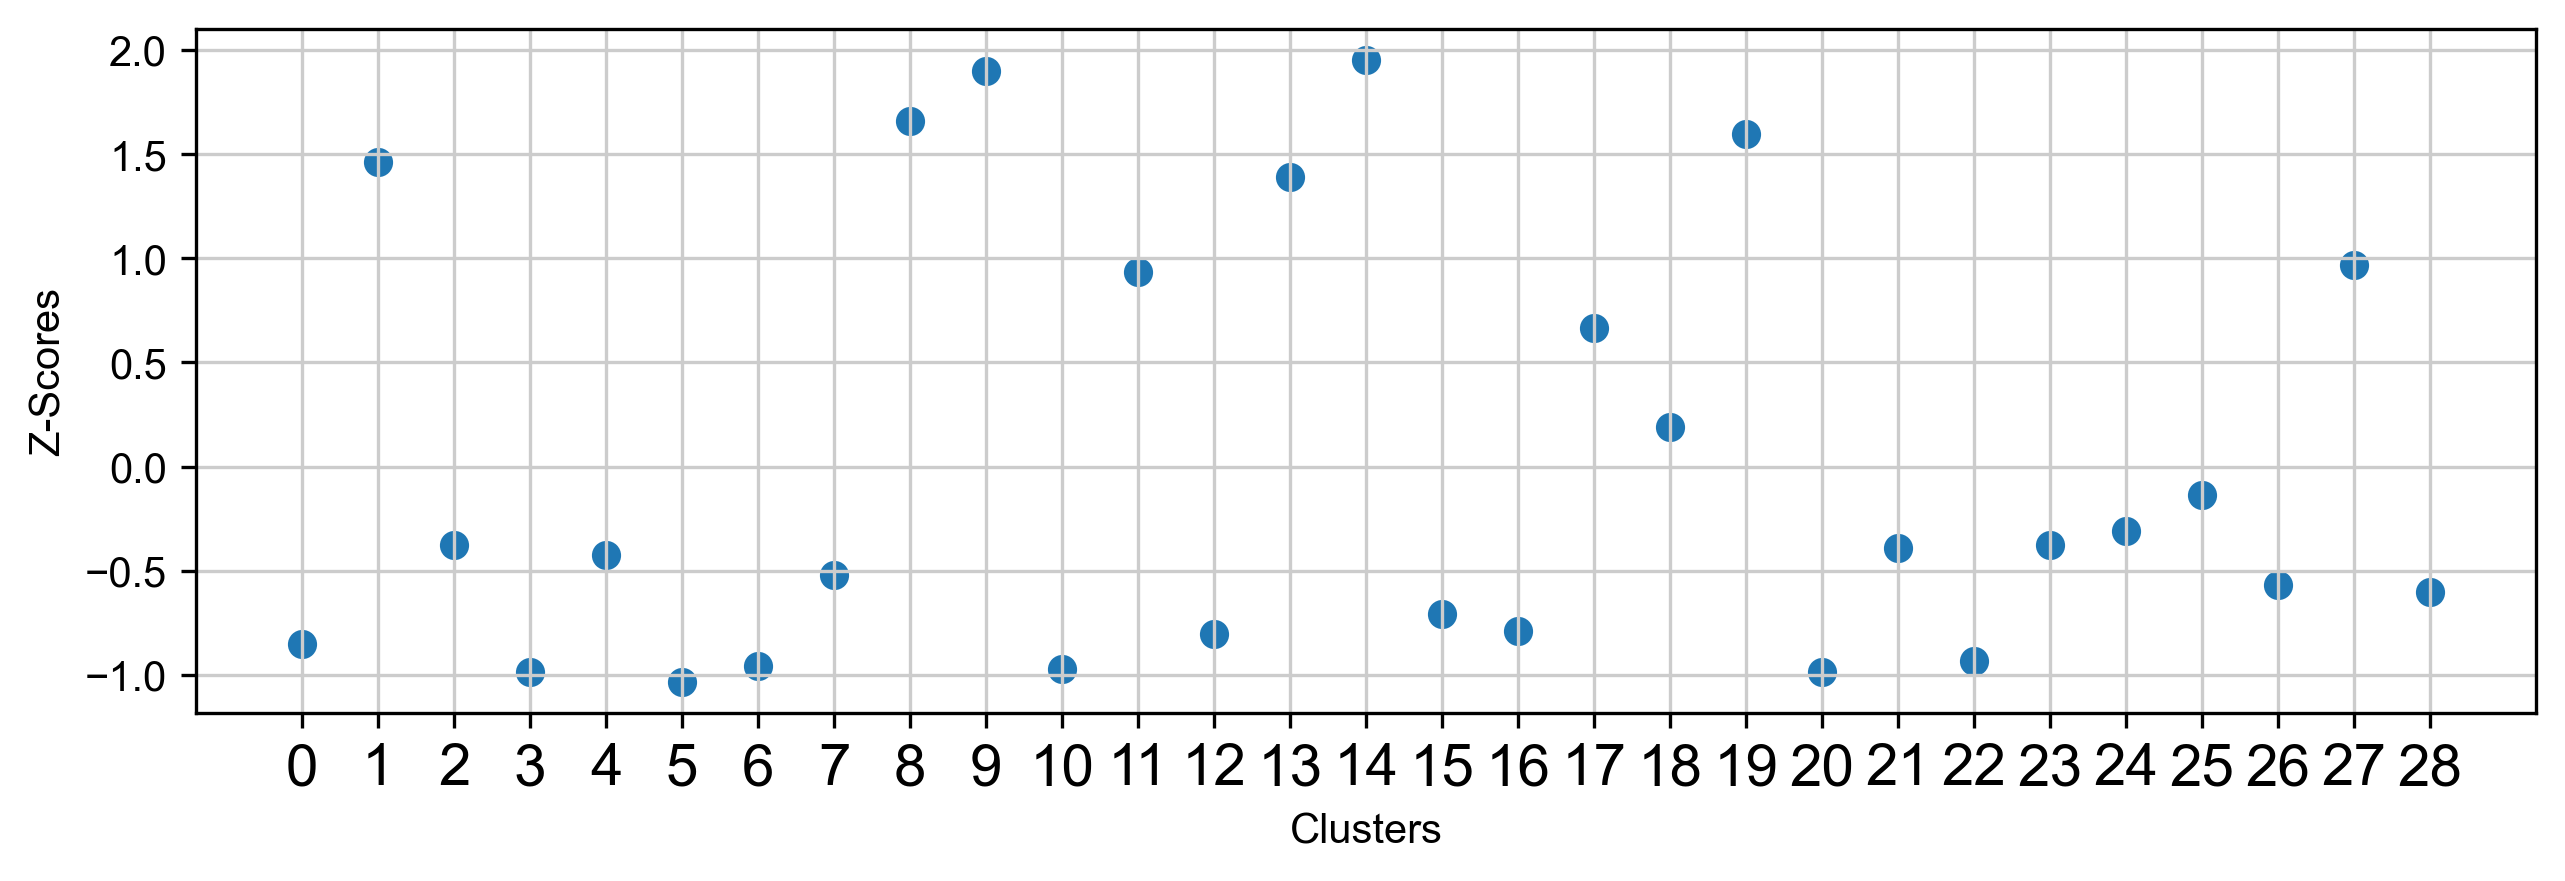

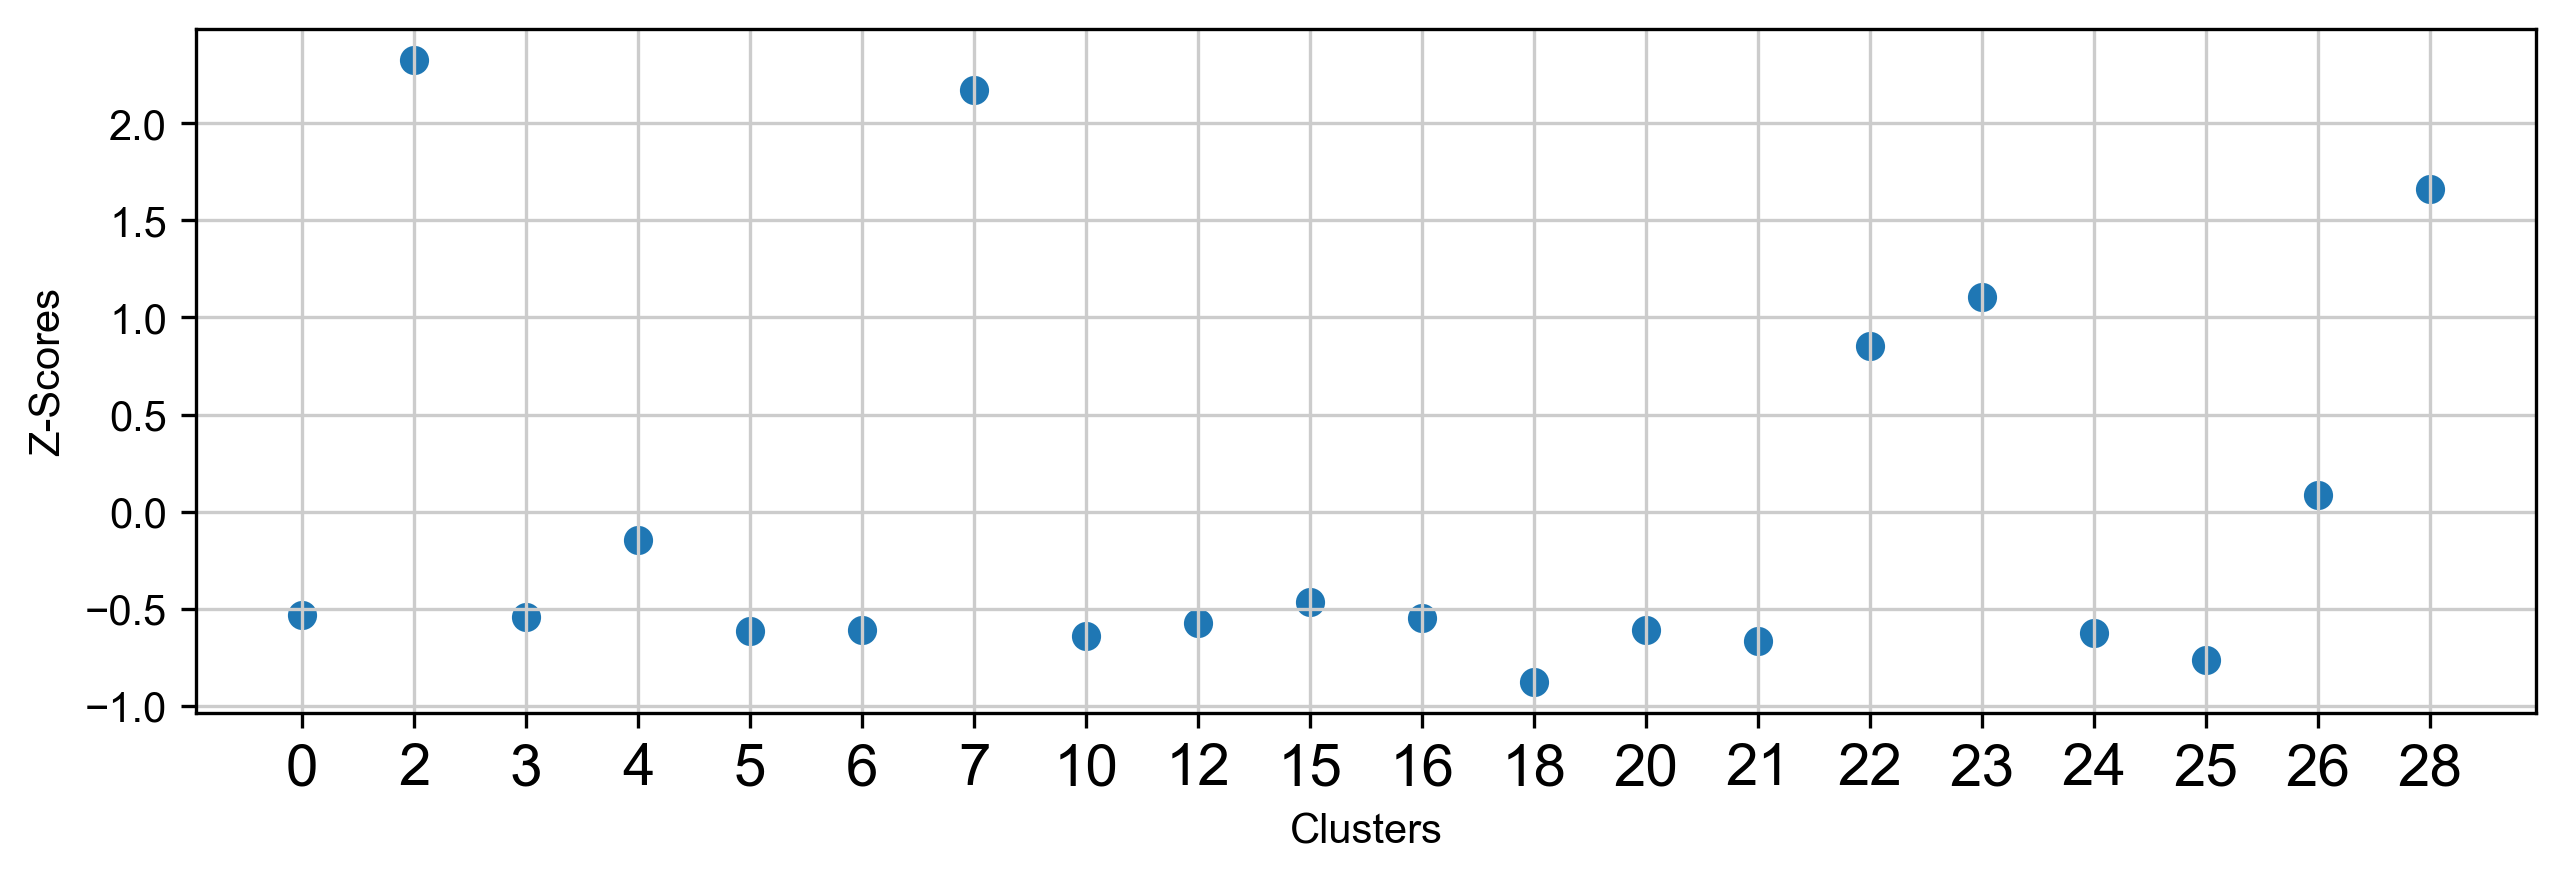

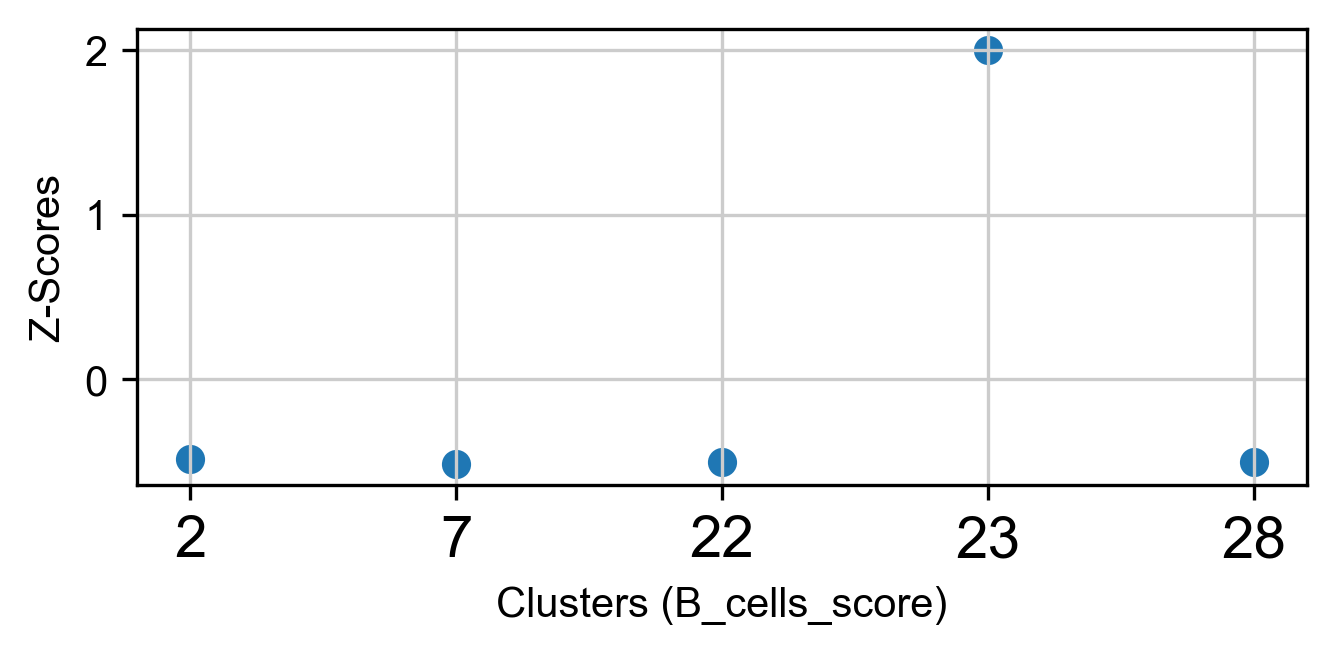

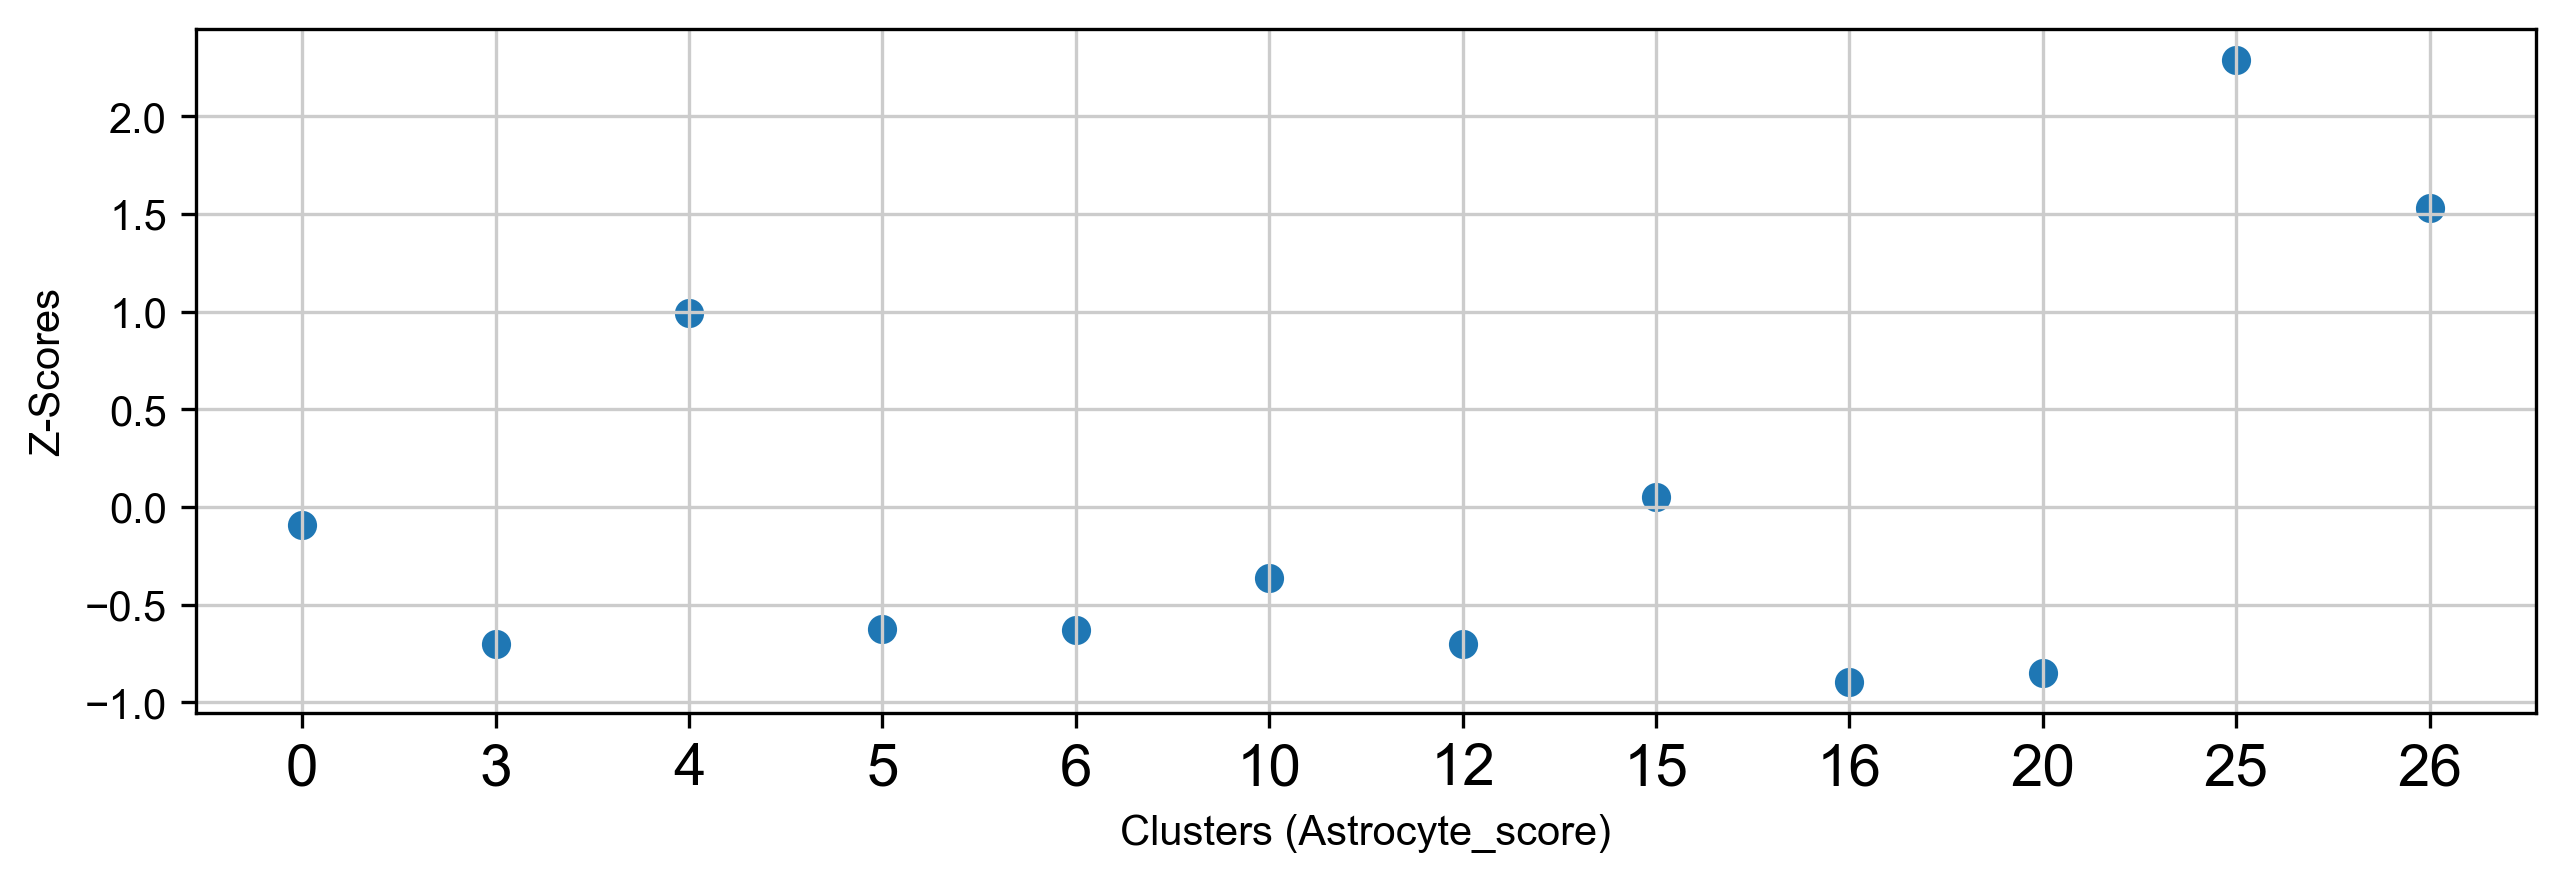

In [24]:
df = annotate_cluster(adata_test, 'Res1_2_AC')
df

# Testing Model on other Data